# 🛍️ Customer Retention Analysis — Exploratory Data Insights

**Dataset:** [Online Retail II (Kaggle)](https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci)  
This notebook explores customer purchasing behavior and identifies key patterns 
that inform feature selection for the churn prediction model.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
RAW_PATH = "../data/raw/online_retail_II.csv"
df = pd.read_csv(RAW_PATH, parse_dates=["InvoiceDate"])


## Data overview


The dataset contains detailed transactional records with the following columns:

| Column | Description |
|---------|-------------|
| `Invoice` | Invoice number (unique per transaction) |
| `StockCode` | Product code |
| `Description` | Product name |
| `Quantity` | Number of items purchased (can be negative for returns) |
| `InvoiceDate` | Date and time of purchase |
| `Price` | Unit price per item |
| `Customer ID` | Unique customer identifier |
| `Country` | Country of the customer |


In [3]:
print(df.shape)
df.head()

(1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom



#### ⚠️ Data quality notes

- Some transactions have missing `Customer ID` — typically guest or unidentified customers.
- Certain rows have negative `Quantity` or `Price` values, which correspond to returns or refunds.
- These negative values will distort monetary statistics (`TotalAmount = Quantity × Price`), so they should be filtered out or corrected before building features.
- Cancelled invoices also start with the letter `'C'` (e.g., `C12345`) and should be excluded.

In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB
None
           Quantity                    InvoiceDate         Price  \
count  1.067371e+06                        1067371  1.067371e+06   
mean   9.938898e+00  2011-01-02 21:13:55.394028544  4.649388e+00   
min   -8.099500e+04            2009-12-01 07:45:00 -5.359436e+04   
25%    1.000000e+00

In [5]:
# Check missing values
df.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [6]:
# Unique customers
print(f"Unique customers: {df['Customer ID'].nunique()}")

Unique customers: 5942


In [7]:
# Remove cancelled/refunded invoices (those starting with 'C')
df = df[~df["Invoice"].astype(str).str.startswith("C")].copy()


## RFM Analysis (Recency, Frequency, and Monetary)

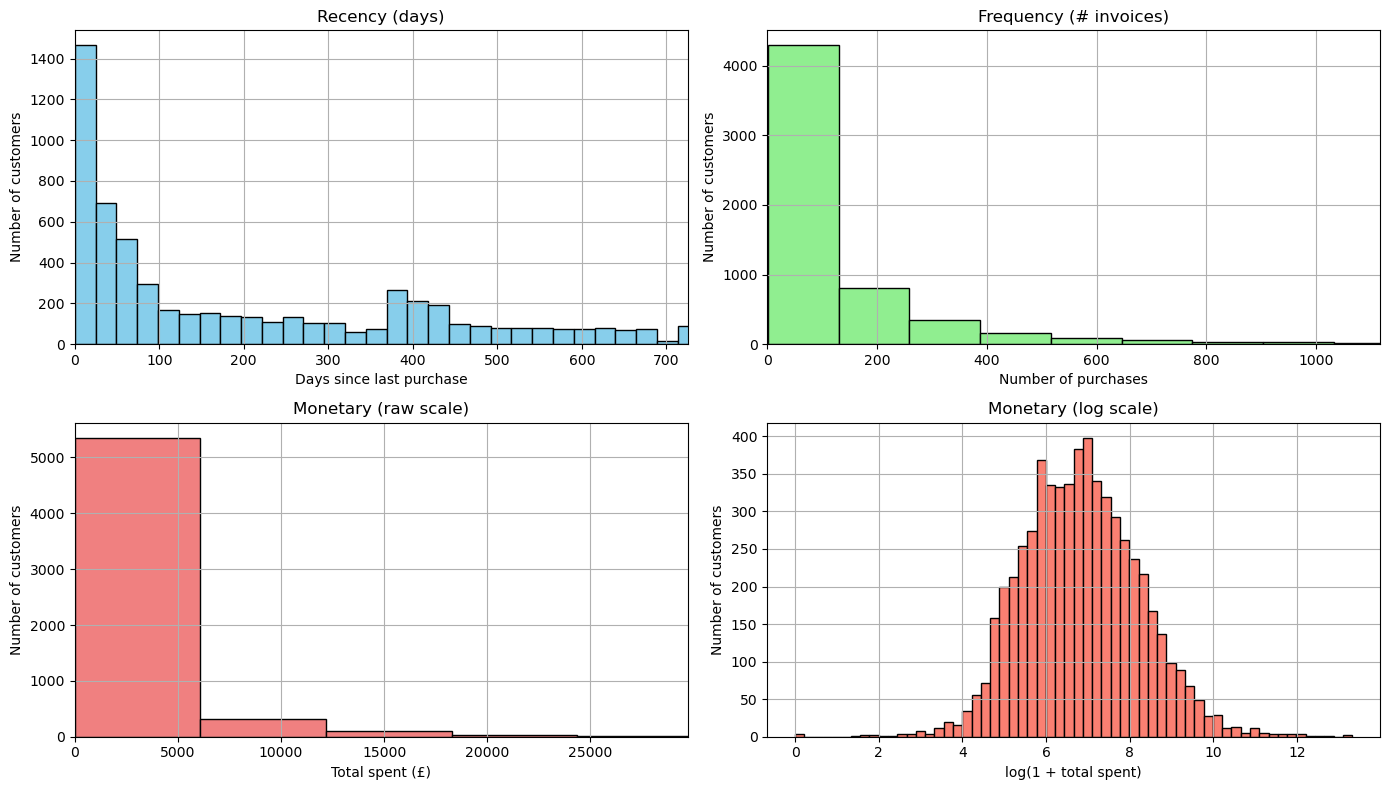

In [8]:
# Monetary: total spent per transaction
df["TotalAmount"] = df["Quantity"] * df["Price"]

# Group by CustomerID
cust = (
    df.groupby("Customer ID")
      .agg({
          "InvoiceDate": ["min", "max"],
          "Invoice": "count",
          "Quantity": "sum",
          "TotalAmount": "sum"
      })
)
cust.columns = ["first_purchase", "last_purchase", "unique_invoices",
                "num_items", "total_spent"]
cust = cust.reset_index()

# Compute recency (days since last purchase relative to dataset max)
cutoff_date = df["InvoiceDate"].max()
cust["recency_days"] = (cutoff_date - cust["last_purchase"]).dt.days
cust["frequency"] = cust["unique_invoices"]
cust["monetary"] = cust["total_spent"]
cust["monetary_log"] = np.log1p(cust["monetary"])

cust[["recency_days", "frequency", "monetary"]].describe()

# Quick histograms
# 2x2 grid layout
fig, ax = plt.subplots(2, 2, figsize=(14, 8))

# Recency
cust["recency_days"].hist(ax=ax[0, 0], bins=30, color="skyblue", edgecolor="black")
ax[0, 0].set_title("Recency (days)")
ax[0, 0].set_xlabel("Days since last purchase")
ax[0, 0].set_ylabel("Number of customers")
ax[0, 0].set_xlim(0, cust["recency_days"].quantile(0.99))

# Frequency
cust["frequency"].hist(ax=ax[0, 1], bins=100, color="lightgreen", edgecolor="black")
ax[0, 1].set_title("Frequency (# invoices)")
ax[0, 1].set_xlabel("Number of purchases")
ax[0, 1].set_ylabel("Number of customers")
ax[0, 1].set_xlim(0, cust["frequency"].quantile(0.99))

# Monetary (raw)
cust["monetary"].hist(ax=ax[1, 0], bins=100, color="lightcoral", edgecolor="black")
ax[1, 0].set_title("Monetary (raw scale)")
ax[1, 0].set_xlabel("Total spent (£)")
ax[1, 0].set_ylabel("Number of customers")
ax[1, 0].set_xlim(0, cust["monetary"].quantile(0.99))

# Monetary (log scale)
cust["monetary_log"].hist(ax=ax[1, 1], bins=60, color="salmon", edgecolor="black")
ax[1, 1].set_title("Monetary (log scale)")
ax[1, 1].set_xlabel("log(1 + total spent)")
ax[1, 1].set_ylabel("Number of customers")

plt.tight_layout()
plt.show()

#### Distribution of Key Behavioral Features

The figure below shows the distribution of the core behavioral features used for retention modeling:

| Feature | Description | Observation |
|----------|--------------|--------------|
| **Recency** | Days since last purchase | Most customers purchased recently, with a small tail of inactive users |
| **Frequency** | Number of purchase occasions | Strongly right-skewed — few customers buy very often |
| **Monetary (raw)** | Total spend per customer | Extremely skewed, dominated by a few high spenders |
| **Monetary (log)** | Log-transformed spend | Nearly normal distribution, more balanced for modeling |

**Note:**  
The x-axes for Recency, Frequency, and Monetary(raw) are trimmed to the 99th percentile  
to remove extreme outliers from visualization while keeping all data points.


## Purchase analysis

In [9]:
CUTOFF_DAYS = 180

In [10]:
# Calculate total orders per customer
cust = (
    df.groupby("Customer ID")
      .agg(
          first_purchase=("InvoiceDate", "min"),
          last_purchase=("InvoiceDate", "max"),
          frequency=("Invoice", "nunique"),
          monetary=("TotalAmount", "sum")
      )
      .reset_index()
)

dataset_end = df["InvoiceDate"].max()
cust["recency_days"] = (dataset_end - cust["last_purchase"]).dt.days

# Gap days
df_sorted = df.sort_values(["Customer ID", "InvoiceDate"])
df_sorted["prev_date"] = df_sorted.groupby("Customer ID")["InvoiceDate"].shift(1)
df_sorted["gap_days"] = (df_sorted["InvoiceDate"] - df_sorted["prev_date"]).dt.days
gap_data = df_sorted["gap_days"].dropna()

print("Gap days summary statistics:")
print(gap_data.describe())


# Repeat customer vs One time customer
cust_orders = (
    df.groupby("Customer ID")["Invoice"]
      .nunique()
      .reset_index(name="num_orders")
)

cust_summary = (
    cust_orders.merge(
        cust[["Customer ID", "monetary", "recency_days", "frequency", "first_purchase", "last_purchase"]],
        on="Customer ID", how="left"
    )
)

cust_summary["is_repeat_customer"] = (cust_summary["num_orders"] > 1).astype(int)

repeat_stats = (
    cust_summary.groupby("is_repeat_customer")
    .agg(
        num_customers=("Customer ID", "count"),
        num_orders=("num_orders", "mean"),
        monetary=("monetary", "mean"),
        recency_days=("recency_days", "mean")
    )
)
total_revenue = cust_summary["monetary"].sum()
rev_share = cust_summary.groupby("is_repeat_customer")["monetary"].sum() / max(total_revenue, 1e-9) * 100
repeat_stats["revenue_share"] = rev_share
repeat_stats = repeat_stats.rename(index={0:"One-time customers",1:"Repeat customers"}).round(2)

print("\nRepeat vs One-time (within observation window):")
print(repeat_stats)


# Cutoff-based Active vs Churn labeling
cutoff_date = df["InvoiceDate"].max() - pd.Timedelta(days=CUTOFF_DAYS)

# - churned: last_purchase < cutoff_date
# - active_or_new: last_purchase >= cutoff_date
# - new_customer: first_purchase >= cutoff_date AND num_orders == 1 (new customer with a single purchase)

cust_summary["status"] = np.where(
    cust_summary["last_purchase"] < cutoff_date, "churned", "active_or_new"
)

cust_summary["new_customer"] = (
    (cust_summary["first_purchase"] >= cutoff_date) & (cust_summary["num_orders"] == 1)
).astype(int)

def segment_row(r):
    if r["status"] == "churned":
        return "churned_repeat" if r["num_orders"] > 1 else "churned_one_time"
    else:  # active_or_new
        if r["new_customer"] == 1:
            return "new_one_time"
        else:
            return "active_repeat" if r["num_orders"] > 1 else "active_one_time"

cust_summary["segment"] = cust_summary.apply(segment_row, axis=1)

seg = (
    cust_summary.groupby("segment")
    .agg(
        customers=("Customer ID", "count"),
        avg_orders=("num_orders", "mean"),
        avg_monetary=("monetary", "mean"),
        avg_recency_days=("recency_days", "mean"),
        revenue=("monetary", "sum"),
    )
    .sort_values("revenue", ascending=False)
)
seg["revenue_share_%"] = seg["revenue"] / max(total_revenue, 1e-9) * 100
seg = seg.drop(columns=["revenue"]).round(2)

print(f"\nCutoff-based segments (cutoff = last_date - {CUTOFF_DAYS} days, cutoff_date={cutoff_date.date()}):")
print(seg)

Gap days summary statistics:
count    799739.000000
mean          1.992006
std          17.921878
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         714.000000
Name: gap_days, dtype: float64

Repeat vs One-time (within observation window):
                    num_customers  num_orders  monetary  recency_days  \
is_repeat_customer                                                      
One-time customers           1626        1.00    349.43        354.33   
Repeat customers             4255        8.31   4036.49        141.66   

                    revenue_share  
is_repeat_customer                 
One-time customers            3.2  
Repeat customers             96.8  

Cutoff-based segments (cutoff = last_date - 180 days, cutoff_date=2011-06-12):
                  customers  avg_orders  avg_monetary  avg_recency_days  \
segment                                                                   
active_repeat          3007       10.07 

#### 🔎 Customer Segmentation Based on Repeat & Churn Behavior

*Cutoff-based segmentation reveals clear patterns of customer loyalty and revenue concentration.*

| Segment | #Customers | Avg #Orders | Avg Monetary | Avg Recency (days) | Revenue Share |
|----------|-------------|--------------|---------------|--------------------|----------------|
| Active Repeat | 3,007 | 10.07 | 5,044.9 | 45.3 | 85.5% |
| Churned Repeat | 1,248 | 4.05 | 1,606.8 | 373.7 | 11.3% |
| Churned One-time | 1,154 | 1.00 | 337.6 | 473.1 | 2.2% |
| New One-time | 472 | 1.00 | 378.4 | 64.0 | 1.0% |

---

- **Active repeat customers (≈3k people)** drive **~85% of revenue** — the backbone of the business.  
  Their purchases are frequent (avg. 10 orders) and recent (avg. 45 days since last purchase).  
  → These are your **core loyal customers** who should be targeted with loyalty or VIP programs.

- **Churned repeat customers (≈1.2k)** still contributed **~11% of total sales**,  
  but have gone inactive for a long time (recency ≈ 374 days).  
  → These are **high-value lost customers**, strong candidates for reactivation campaigns.

- **Churned one-time buyers (≈1.1k)** represent the typical *“bought once and never returned”* group.  
  → Low monetary value and very long inactivity (recency ≈ 473 days).  
  → Suggests issues in **first-time experience** or **onboarding**.

- **New one-time customers (≈470)** entered near the end of the dataset.  
  → Not necessarily churned yet; they simply didn’t have enough time to repurchase.  
  → Treat them separately from actual churned users.

---

**Analytical Notes**

- The cutoff date (`2011-06-12`) was set **180 days before the dataset’s end** to distinguish *recently active* vs *long inactive* customers, allowing us to avoid falsely labeling late joiners as “churned”.  
- Future retention models should use this **cutoff-based labeling** rather than a simple “one-time vs repeat” rule.
- During EDA, the `gap_days` feature (average days between purchases) was tested but found to be extremely zero-inflated about 75% of values were 0, meaning many customers placed multiple orders on the same day. Because of this low variance and weak predictive power, it was excluded from the final modeling features.  
- The final feature focus aligns with RFM principles: **Recency, Frequency, Monetary** remain the strongest predictors of churn behavior.
